Input  >>> i love you.
Output >>> seni seviyorum . <eos>


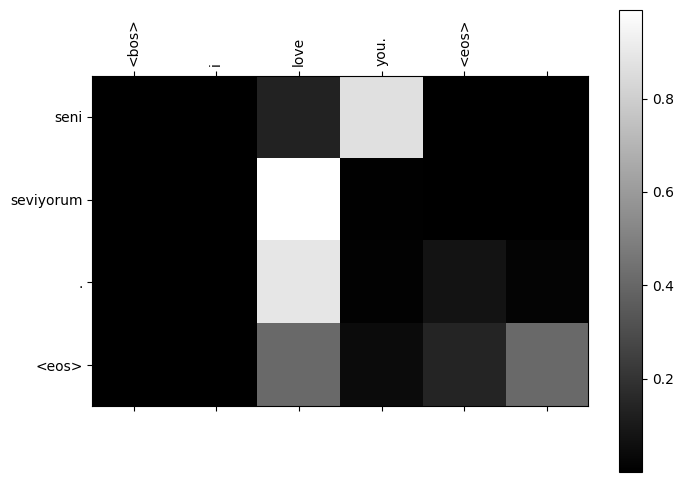

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 18 09:28:45 2023

@author: VuralBayraklii
"""

from seq2seqmodel import (BahdanauAttentionQKV, 
                          BahdanauDecoder, 
                          BahdanauEncoder, 
                          BahdanauSeq2Seq, 
                          MultipleOptimizer)
from torchtext.data.utils import get_tokenizer
import warnings

warnings.filterwarnings("ignore")
import pickle
import torch
from matplotlib import ticker
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

ENCODER_EMBEDDING_DIM = 256
ENCODER_HIDDEN_SIZE = 256
DECODER_EMBEDDING_DIM = 256
DECODER_HIDDEN_SIZE = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

with open(os.path.join("pickles", "en_vocab.pkl"), "rb") as f:
    en_vocab = pickle.load(f)
    
with open(os.path.join("pickles", "tr_vocab.pkl"), "rb") as f:
    tr_vocab = pickle.load(f)    

enc = BahdanauEncoder(input_dim=len(en_vocab),
                      embedding_dim=ENCODER_EMBEDDING_DIM, 
                      encoder_hidden_dim=ENCODER_HIDDEN_SIZE, 
                      decoder_hidden_dim=DECODER_HIDDEN_SIZE, 
                      dropout_p=0.15)

attn = BahdanauAttentionQKV(DECODER_HIDDEN_SIZE)

dec = BahdanauDecoder(output_dim=len(tr_vocab), 
                      embedding_dim=DECODER_EMBEDDING_DIM,
                      encoder_hidden_dim=ENCODER_HIDDEN_SIZE, 
                      decoder_hidden_dim=DECODER_HIDDEN_SIZE,
                      attention=attn,
                      dropout_p=0.15)

seq2seq = BahdanauSeq2Seq(enc, dec, device)

model_path = os.path.join(os.getcwd(), "bahdanau_en_tr.pt")

seq2seq.load_state_dict(torch.load(model_path, map_location=device))

PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

def predict_text(model, text, device=device, src_vocab=en_vocab, src_tokenizer=en_tokenizer, tgt_vocab=tr_vocab):
    model.eval()
    with torch.no_grad():
        text = text.lower()
        input_ids = [src_vocab[token] for token in src_tokenizer(text)]
        input_ids = [BOS_IDX] + input_ids + [EOS_IDX]
        input_tensor = torch.tensor(input_ids).to(device).unsqueeze(1) # add fake batch dim
        max_len = 2*len(input_ids)
        encoder_outputs, hidden = model.encoder(input_tensor)
        
        output = torch.tensor([BOS_IDX]).to(device)
        
        decoder_outputs = torch.zeros(max_len, 1, len(tgt_vocab)).to(device)
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_len, len(input_ids))
        for t in range(0, max_len):
            output, hidden, attn = model.decoder(output, hidden, encoder_outputs)
            decoder_attentions[t] = attn.data
            decoder_outputs[t] = output
            output = output.argmax(1)
            
            if output.item() == EOS_IDX:
                decoded_words.append('<eos>')
                break
            else:
                decoded_words.append(tgt_vocab.lookup_token(output.item()))
        
        output_sentence = ' '.join(decoded_words)
        return output_sentence, decoder_attentions[:(t+1)]

def show_attention(input_sentence, output_sentence, attentions, figsize=(8,6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='gray')
    fig.colorbar(cax)
    
    src = ['', '<bos>'] + input_sentence.split(' ') + ['<eos>']
    tgt = [''] + output_sentence.split(' ')
    ax.set_xticklabels(src, rotation=90)
    ax.set_yticklabels(tgt)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def predict_and_show_attention(sentence, model, device):
    result, attentions = predict_text(model, sentence, device)
    
    print("Input  >>>", sentence)
    print("Output >>>", result)
    
    show_attention(sentence, result, attentions)
    
predict_and_show_attention("i love you.", seq2seq, device)



Input  >>> i am studying computer engineering!
Output >>> bilgisayar bilimleri okuyorum . <eos>


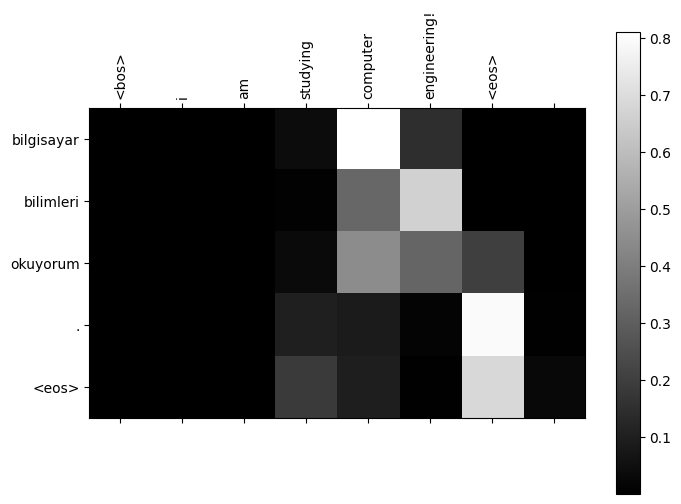

In [10]:
predict_and_show_attention("i am studying computer engineering!", seq2seq, device)


Input  >>> i will do what i must to do.
Output >>> ne yapmam gerekiyorsa yapacağım . <eos>


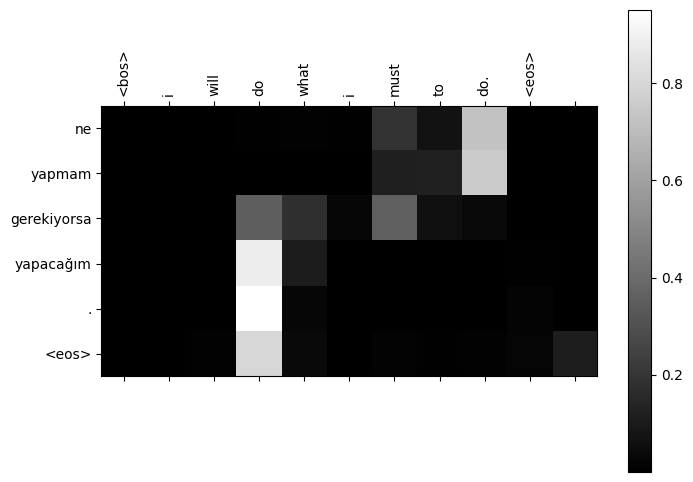

In [26]:
predict_and_show_attention("i will do what i must to do.", seq2seq, device)
